# SIMPL demo 

<img src="../simpl.gif" width=850>

This demo loads an artificial dataset (the grid cell dataset of figure 3) and train SIMPl to recover the underlying latent space. 

## Load data
SIMPL requires spikes (`Y`), an initial latent variable (`Xb`), and time stamps (`time`). 
Optionally, if you have them, you can also provide ground truth latent variables and tuning curves for evaluation.


In [15]:
# Standard imports
import matplotlib
import matplotlib.pyplot as plt

from simpl import SIMPL, load_datafile

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load some premade artificial data:

In [16]:
data = load_datafile("gridcelldata.npz")

print("Required data:")
Y_all = data["Y"]
print(f"   {'Y, spikes:': <30}{Y_all.shape}")
Xb_all = data["Xb"]
print(f"   {'Xb, latent initialisation:': <30}{Xb_all.shape}")
time_all = data["time"]
print(f"   {'time, time stamps:': <30}{time_all.shape}")

# optionally, if you have the ground truth trajcetory and tuning curves you can use these too
print("\nOptional ground truth data and other coordinates. You DONT need to have these:")
Xt_all = data["Xt"]
print(f"   {'Xt, ground truth:': <30}{Xt_all.shape}")
dims = data["dim"]
print(f"   {'dim, dimension names:': <30}{dims.shape}")
neuron = data["neuron"]
print(f"   {'neuron, neuron IDs:': <30}{neuron.shape}")
Ft = data["Ft"]
print(f"   {'Ft, tuning curves:': <30}{Ft.shape}")
xbins = data["x"]
print(f"      {'xbins:': <27}{xbins.shape}")
ybins = data["y"]
print(f"      {'ybins:': <27}{ybins.shape}")

# Hold out the last 60 seconds for prediction
dt = float(time_all[1] - time_all[0])
N_test = int(60 / dt)
N_train = len(time_all) - N_test

Y = Y_all[:N_train]
Xb = Xb_all[:N_train]
time = time_all[:N_train]
Xt = Xt_all[:N_train]

Y_test = Y_all[N_train:]
Xb_test = Xb_all[N_train:]
Xt_test = Xt_all[N_train:]

print(f"\nTrain/test split: {N_train} train bins ({N_train * dt:.0f}s), {N_test} test bins ({N_test * dt:.0f}s)")

Required data:
   Y, spikes:                    (36000, 225)
   Xb, latent initialisation:    (36000, 2)
   time, time stamps:            (36000,)

Optional ground truth data and other coordinates. You DONT need to have these:
   Xt, ground truth:             (36000, 2)
   dim, dimension names:         (2,)
   neuron, neuron IDs:           (225,)
   Ft, tuning curves:            (225, 100, 100)
      xbins:                     (100,)
      ybins:                     (100,)

Train/test split: 35400 train bins (3540s), 600 test bins (60s)


## Create and fit the SIMPL model

SIMPL is initialised with hyperparameters only. Data is passed to `fit()`. The environment is created internally from the data (you can override with `environment=` if needed).

Key parameters:
- `bin_size` / `env_pad`: control the spatial discretisation
- `speed_prior`: prior on agent speed (m/s) — controls Kalman smoothing strength
- `kernel_bandwidth`: KDE bandwidth for fitting tuning curves

In [20]:
PAD = 0.0
DX = 0.02

simpl_model = SIMPL(
    kernel_bandwidth=0.02,
    speed_prior=0.4,
    bin_size=DX,
    env_pad=PAD,
)

simpl_model.fit(Y, Xb, time, n_epochs=5)

ENVIRONMENT:
  Extent:     [0.00, 1.00] x [0.00, 1.00] (Xb: [0.00, 1.00] x [0.00, 1.00])
  Bin size:   0.02
  Grid shape: (50, 50) (2500 bins)
  Padding:    0.0

DATA SUMMARY:
  Neurons:    225
  Dimensions: 2
  dt:         0.10000000149011612 s
  Duration:   3540.0 s (35400 bins)
  Trials:     1
  Neuron firing rate (Hz): mean 0.95, min 0.54, Q1 0.78, median 0.93, Q3 1.10, max 1.55
  Median speed:     0.086 m/s
  Mean distance travelled per dt: 0.0093 m (may guide your choice of dx)
  Simultaneously active neurons per bin:
    0  = 0%
    1  = 0%
    2  = 0%
    3+ ============================== 100%
  Spatial information (bits/s per neuron): mean 0.42, min 0.15, Q1 0.25, median 0.35, Q3 0.57, max 0.99
  Total spatial information rate: 94.5 bits/s

Epoch 0  :    log-likelihood(train=-0.195, test=-0.220)     spatial_info=0.420 bits/s/neuron
Epoch 1  :    log-likelihood(train=-0.106, test=-0.113)     spatial_info=1.710 bits/s/neuron
Epoch 2  :    log-likelihood(train=-0.077, test=-0.082

In [21]:
# Use ground truth Xt and Ft to calculate baseline metrics
# If you don't have ground truth, skip this cell
simpl_model.add_baselines_to_results(
    Xt=Xt,
    Ft=Ft,
    Ft_coords_dict={"x": xbins, "y": ybins},
)

## Extract the results 

All results are stored in `simpl_model.results_` (an xarray.Dataset). Quick access to the final decoded latent and fitted receptive fields is also available via `simpl_model.X_` and `simpl_model.F_`.

Epochs -1 and -2 (if present) represent baselines computed from ground truth.

The most important results are: 
- `results.F`: tuning curves across epochs
- `results.X`: inferred latent variables across epochs
- `results.logPYXF`: log likelihood of the data given the inferred latent variables and tuning curves
- `results.Xt`: ground truth latent variables (if baselines were added)
- `results.Ft`: ground truth tuning curves (if baselines were added)

In [5]:
results = simpl_model.results_

### Plot latent at epochs 0, 1, 2,... alongside the true latent (if available)

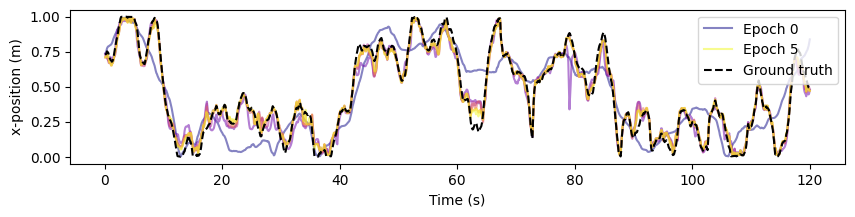

In [6]:
timeslice = slice(0, 120)
t = results.time.sel(time=timeslice).values

fig, ax = plt.subplots(1, 1, figsize=(10, 2))
for epoch in range(0, results.epoch.values[-1] + 1):
    X = results.X.sel(epoch=epoch, time=timeslice).values
    ax.plot(
        t,
        X[:, 0],
        color=matplotlib.cm.plasma(epoch / results.epoch.values[-1]),
        alpha=0.5,
        label=(f"Epoch {epoch}" if epoch in [0, results.epoch.values[-1]] else None),
    )

if "Xt" in results.keys():
    XT = results.Xt.sel(time=timeslice).values
    ax.plot(t, XT[:, 0], "k", ls="--", label="Ground truth")
ax.set_xlabel("Time (s)")
ax.set_ylabel("x-position (m)")
ax.legend()

### Plot the receptive field of one of the neurons at epoch 0, 1, 2,... alongside the true receptive field

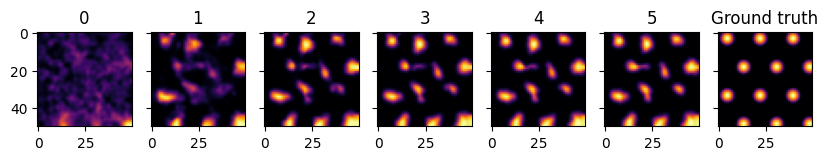

In [7]:
fig, ax = plt.subplots(1, results.epoch.values[-1] + 2, figsize=(10, 2), sharex=True, sharey=True)
for epoch in range(0, results.epoch.values[-1] + 1):
    F = results.F.sel(epoch=epoch, neuron=10)
    ax[epoch].imshow(F, cmap="inferno")
    ax[epoch].set_title(f"{epoch}")
    # edge_map = results.place_field_outlines.sel(epoch=epoch, neuron=10).values[::-1].astype(float)
    # edge = ax[epoch].imshow(edge_map,extent=env.extent, cmap='Greys_r', alpha=edge_map,zorder=10)

if "Ft" in results.keys():
    FT = results.Ft.sel(neuron=10)
    ax[-1].imshow(FT.T[::-1, ::-1], cmap="inferno")
    ax[-1].set_title("Ground truth")
else:
    ax[-1].set_title("No ground truth :(")
    ax[-1].axis("off")

### Plot the log-likelihood of spikes at each epoch


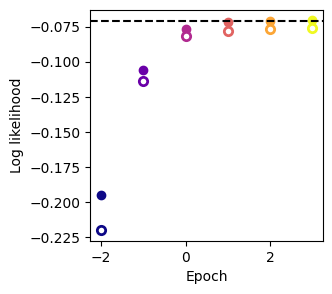

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
for i in range(0, results.epoch.values[-1] + 1):
    ax.scatter(
        results.epoch[i],
        results.logPYXF.sel(epoch=i),
        label=f"Epoch {i}",
        color=matplotlib.cm.plasma(i / results.epoch.values[-1]),
    )
    ax.scatter(
        results.epoch[i],
        results.logPYXF_test.sel(epoch=i),
        label=f"Epoch {i}",
        color="w",
        edgecolors=matplotlib.cm.plasma(i / results.epoch.values[-1]),
        linewidth=2,
    )
ax.set_xlabel("Epoch")
ax.set_ylabel("Log likelihood")
if -1 in results.epoch.values:
    ax.axhline(results.logPYXF.sel(epoch=-1), color="k", ls="--", label="Ground truth")

## Prediction

Use `predict()` to decode new spikes using the fitted receptive fields. The full decode output (smoothed means, covariances, log-likelihoods) is stored in `model.prediction_results_` as an `xr.Dataset`.

In [9]:
X_pred = simpl_model.predict(Y_test)
print(f"Predicted shape: {X_pred.shape}")
print(f"\nprediction_results_ variables: {list(simpl_model.prediction_results_.data_vars)}")

Predicted shape: (600, 2)

prediction_results_ variables: ['mu_l', 'mode_l', 'sigma_l', 'mu_f', 'sigma_f', 'mu_s', 'sigma_s', 'logPYF', 'logPYF_test']


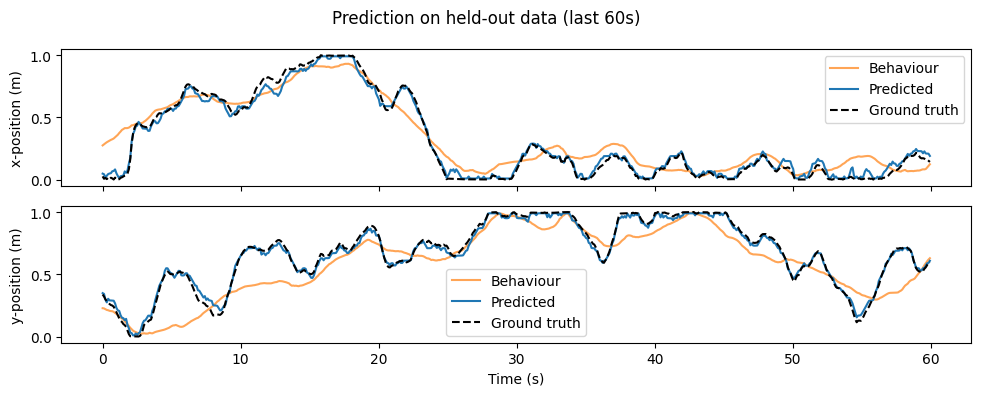

In [11]:
t_pred = simpl_model.prediction_results_.time.values  # access time from rich prediction results

fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
for i, dim_label in enumerate(["x", "y"]):
    axes[i].plot(t_pred, Xb_test[:, i], color="tab:orange", alpha=0.7, label="Behaviour")
    axes[i].plot(t_pred, X_pred[:, i], label="Predicted")
    axes[i].plot(t_pred, Xt_test[:, i], "k", ls="--", label="Ground truth")
    axes[i].set_ylabel(f"{dim_label}-position (m)")
    axes[i].legend()
axes[-1].set_xlabel("Time (s)")
fig.suptitle("Prediction on held-out data (last 60s)")
fig.tight_layout()